In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
Moggio = read_csv('Quadranti.csv')
Moggio.head()

,Unnamed: 0,index,Date,Ammonia,PM10,PM25,Wind_speed,Temperature,Rainfall,Quadrante
0,0,0,2014-01-01T00:00:00Z,0.0,6.0,7.0,0.443554,-0.334965,0.0,2
1,1,1,2014-01-02T00:00:00Z,0.0,6.0,5.0,0.355915,-0.486111,7.8,2
2,2,2,2014-01-03T00:00:00Z,0.0,11.0,4.0,0.207631,2.220588,0.0,2
3,3,3,2014-01-04T00:00:00Z,0.0,6.0,7.0,1.024926,2.137063,35.8,2
4,4,4,2014-01-05T00:00:00Z,0.0,3.0,8.0,0.666721,2.416084,25.0,2


In [3]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


,level_0,Unnamed: 0,index,Date,Ammonia,PM10,PM25,Wind_speed,Temperature,Rainfall,Quadrante
0,0,0,0,2014-01-01T00:00:00Z,0.0,6.0,7.0,0.443554,-0.334965,0.0,2
1,1,1,1,2014-01-02T00:00:00Z,0.0,6.0,5.0,0.355915,-0.486111,7.8,2
2,2,2,2,2014-01-03T00:00:00Z,0.0,11.0,4.0,0.207631,2.220588,0.0,2
3,3,3,3,2014-01-04T00:00:00Z,0.0,6.0,7.0,1.024926,2.137063,35.8,2
4,4,4,4,2014-01-05T00:00:00Z,0.0,3.0,8.0,0.666721,2.416084,25.0,2


##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [6]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [9]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

ValueError: could not convert string to float: '2014-01-01T00:00:00Z'

In [ ]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312,)
(1312, 5, 6) (1312,) (419, 5, 6) (419,)


# Modeling and training

In [10]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-02-02 11:18:33.689974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-02 11:18:33.690938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


NameError: name 'train_X' is not defined

## Predictions of the year 2019

In [ ]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.889


#### Prediciton plots

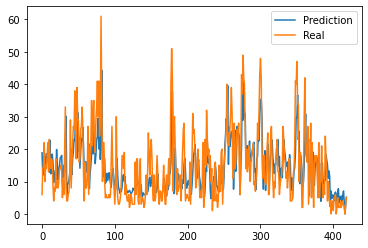

In [ ]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

# Modeling with hyperparamenter search
# Goal: reduce the MSE without overfitting

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.2 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt #Keras Creates a better model

In [ ]:
tf.config.list_physical_devices('GPU') #To undestand which GPU using during the training

[]

## Function to create new models

In [ ]:
def model_builder(hp):
  #design network
  #object created with keras_tuner -> iterates some parameters to create the model
  #units = neurons we use 32 steps for each time
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  #Initialization of the model
  model = Sequential() 
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  #for loop to iterate different quantities of layer (from 1 to 3 layer)
  for i in range(hp.Int('layers',1,3)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  #Choose from a list of given instructions -> we choose leanrning rates
  #We look the performances
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

# Creation of the object with model_builder(hp)
## Parameter to look at: validation loss

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =3,
    directory = 'dir',
    project_name = 'namee')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

Trial 10 Complete [00h 16m 14s]
val_loss: 0.08407227694988251

Best val_loss So Far: 0.06101139013965925
Total elapsed time: 01h 00m 09s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in dir/namee
Showing 10 best trials
Objective(name='val_loss', direction='min')


### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [ ]:
tuner.search(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])